<a href="https://colab.research.google.com/github/vilsaira/example/blob/main/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dipy
!git clone https://github.com/vilsaira/example
import numpy as np
import nibabel as nib
from scipy import optimize
import matplotlib.pyplot as plt
import dipy
import os
from google.colab import files

     |████████████████████████████████| 7.7 MB 7.8 MB/s 
Cloning into 'example'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [2]:
GT_ADC = np.array([0.00089])
def exponential_decay(s=1000, bvalue=1000, ADC=GT_ADC, SNR=np.inf):
  sigma = s/SNR
  return s * np.exp(-bvalue * ADC) + np.random.normal(0, sigma, 1)

def fun_lin(x,a,b):
  return a * x + b

def fun_exp(x,a,b):
  return a * np.exp(-b * x)

Simulation of the diffusion weighted signal

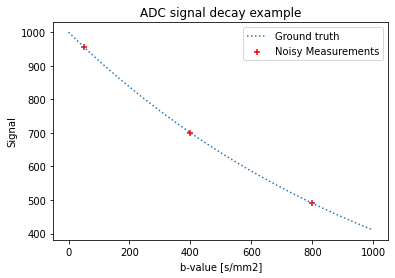

In [3]:
np.random.seed(405)
# Test different simulation parameters
bvalues = np.array([50,400,800])
bvalues = np.repeat(bvalues, 1)
SNR = np.inf # e.g. np.inf
measurements = np.array([exponential_decay(bvalue=bvalues[i], SNR=SNR)[0] for i in range(len(bvalues))])

x = np.array(range(1000))
plt.plot(x, [exponential_decay(bvalue=i)[0] for i in x], label='Ground truth', linestyle='dotted')
plt.scatter(bvalues, measurements , label='Noisy Measurements', color='red', marker='+')
plt.xlabel('b-value [s/mm2]')
plt.ylabel('Signal')
plt.title('ADC signal decay example')
plt.legend()

Exercise #1 ADC linear fitting

> Ignore assumptions on IVIM (i.e. non-exponential decay on low b-values)



Ground truth ADC = 0.890 *10^(-3) mm^2/s
Measured ADC = 0.890 *10^(-3) mm^2/s
Relative error = -0.0%


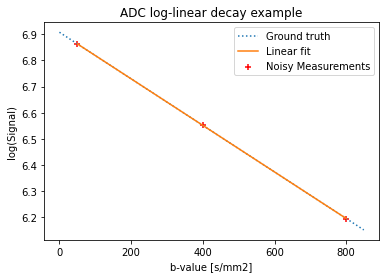

In [4]:
log_measurements = np.log(measurements)
# change middle point value
#log_measurements[0] = 0.95*log_measurements[0] # ~ 50% virhe
#log_measurements[1] = 0.95*log_measurements[1] # ~ 2.2% virhe
#log_measurements[2] = 0.95*log_measurements[2] # ~ 47% virhe

linfit_params, params_covariance = optimize.curve_fit(fun_lin, bvalues, log_measurements, [0.001, 7])

x = range(850)
plt.plot(x, np.log([exponential_decay(bvalue=i)[0] for i in x]), label='Ground truth', linestyle='dotted')
plt.scatter(bvalues, log_measurements , label='Noisy Measurements', color='red', marker='+')
plt.plot(bvalues, fun_lin(bvalues, linfit_params[0], linfit_params[1]), label='Linear fit')
plt.xlabel('b-value [s/mm2]')
plt.ylabel('log(Signal)')
plt.title('ADC log-linear decay example')
plt.legend()

RE = (-linfit_params[0] - GT_ADC) / GT_ADC * 100
print(f"Ground truth ADC = {GT_ADC[0]*1000:.3f} *10^(-3) mm^2/s")
print(f"Measured ADC = {-linfit_params[0]*1000:.3f} *10^(-3) mm^2/s")
print(f"Relative error = {RE[0]:1.1f}%")


Exercise #2 ADC non-linear fitting

Ground truth ADC = 0.890 *10^(-3) mm^2/s
Measured ADC = 0.890 *10^(-3) mm^2/s
Relative error = -0.0%


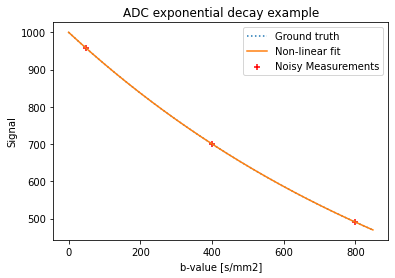

In [5]:
measurements2 = measurements.copy()
# change middle point value
# measurements2[0] = 0.95*measurements2[0] # ~ 9.2% virhe
# measurements2[1] = 0.95*measurements2[1] # ~ 3.2% virhe
# measurements2[2] = 0.95*measurements2[2] # ~ 6.1% virhe

expfit_params, _ = optimize.curve_fit(fun_exp, bvalues, measurements2, [1000, 0.0001])

x = np.array(range(850))
plt.plot(x, [exponential_decay(bvalue=i)[0] for i in x], label='Ground truth', linestyle='dotted')
plt.scatter(bvalues, measurements2 , label='Noisy Measurements', color='red', marker='+')
plt.plot(x, [fun_exp(i, expfit_params[0], expfit_params[1]) for i in x], label='Non-linear fit')
plt.xlabel('b-value [s/mm2]')
plt.ylabel('Signal')
plt.title('ADC exponential decay example')
plt.legend()

RE = (expfit_params[1] - GT_ADC) / GT_ADC * 100
print(f"Ground truth ADC = {GT_ADC[0]*1000:.3f} *10^(-3) mm^2/s")
print(f"Measured ADC = {expfit_params[1]*1000:.3f} *10^(-3) mm^2/s")
print(f"Relative error = {RE[0]:1.1f}%")

Exercise #3 Noise propagation in diffusion tensor modelling
> Consider the condition number of the linear problem of two design matrices A1 and A2 that could be used in diffusion tensor modelling

In [6]:
# Bad gradient directions
G1 = np.array([[ 0.7311,  0.1166, -0.6722], \
               [ 0.5045,  0.0713,  0.8605], \
               [-0.8907, -0.1534, -0.4278], \
               [ 0.5673, -0.3938,  0.7232], \
               [ 0.5645, -0.3286,  0.7572], \
               [ 0.3774, -0.1172, -0.9186]])
# Bad design matrix
A1 = np.array([G1[:,0] ** 2, \
      G1[:,1] ** 2, \
      G1[:,2] ** 2, \
      2 * G1[:,0] * G1[:,1], \
      2 * G1[:,0] * G1[:,2], \
      2 * G1[:,1] * G1[:,2]]).transpose()

logS1 = np.array([1, 1, 1, 1, 1, 1]) # Hypothetical measurements with log-linearisation
logS2 = np.array([1, 1, 1, 1, 1, 0.95]) # Introducing 5% error in the measurements

D1 = np.dot(np.linalg.pinv(A1), logS1)
D2 = np.dot(np.linalg.pinv(A1), logS2)

print(f"D1 elements with bad design matrix [{D1[0]:.2f}, {D1[1]:.2f}, {D1[2]:.2f}, {D1[3]:.2f}, {D1[4]:.2f}, {D1[5]:.2f}]")
print(f"D2 elements with bad design matrix [{D2[0]:.2f}, {D2[1]:.2f}, {D2[2]:.2f}, {D2[3]:.2f}, {D2[4]:.2f}, {D2[5]:.2f}]")
ER = (D2 - D1) / D1 * 100
print(f"Element-wise relative errors [{ER[0]:1.1f}, {ER[1]:1.1f}, {ER[2]:1.1f}, {ER[3]:1.1f}, {ER[4]:1.1f}, {ER[5]:1.1f}] %")
print(f"The condition number of the bad design matrix A1 = {np.linalg.cond(A1):1.2f}")


D1 elements with bad design matrix [1.00, 1.00, 1.00, -0.00, -0.00, 0.00]
D2 elements with bad design matrix [0.94, 1.12, 1.00, 0.16, 0.01, -0.10]
Element-wise relative errors [-5.6, 11.7, 0.2, -418273.2, -36013.6, -51125.9] %
The condition number of the bad design matrix A1 = 114.78


In [7]:
# Good gradient directions based on electrostatic repulsion (i.e. Thomson Problem)
G2 = np.array([[ 1,      0.0,    0.0], \
               [ 0.446,  0.895,  0.0], \
               [ 0.447,  0.275, -0.851], \
               [ 0.448, -0.723, -0.525], \
               [ 0.447, -0.724,  0.526], \
               [-0.449, -0.277, -0.85]])
# Bad design matrix
A2 = np.array([G2[:,0] ** 2, \
      G2[:,1] ** 2, \
      G2[:,2] ** 2, \
      2 * G2[:,0] * G2[:,1], \
      2 * G2[:,0] * G2[:,2], \
      2 * G2[:,1] * G2[:,2]]).transpose()

D1 = np.dot(np.linalg.pinv(A2), logS1)
D2 = np.dot(np.linalg.pinv(A2), logS2)

print(f"D1 elements with bad design matrix [{D1[0]:.2f}, {D1[1]:.2f}, {D1[2]:.2f}, {D1[3]:.2f}, {D1[4]:.2f}, {D1[5]:.2f}]")
print(f"D2 elements with bad design matrix [{D2[0]:.2f}, {D2[1]:.2f}, {D2[2]:.2f}, {D2[3]:.2f}, {D2[4]:.2f}, {D2[5]:.2f}]")
ER = (D2 - D1) / D1 * 100
print(f"Element-wise relative errors [{ER[0]:1.1f}, {ER[1]:1.1f}, {ER[2]:1.1f}, {ER[3]:1.1f}, {ER[4]:1.1f}, {ER[5]:1.1f}] %")
print(f"The condition number of the good design matrix A1 = {np.linalg.cond(A2):1.2f}")

D1 elements with bad design matrix [1.00, 1.00, 1.00, -0.00, -0.00, 0.00]
D2 elements with bad design matrix [1.00, 1.01, 0.97, -0.01, -0.02, -0.01]
Element-wise relative errors [0.0, 0.8, -3.3, 4924.4, 2289.5, -3572.8] %
The condition number of the good design matrix A1 = 1.58


Exercise #4 Outliers in data
> Lets use the example data downloaded from the github

In [8]:
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

img = nib.load("/content/example/example.nii.gz")
data = img.get_fdata()
bvals, bvecs = read_bvals_bvecs("/content/example/example.bval", "/content/example/example.bvec")

gtab = gradient_table(bvals, bvecs)
#print(gtab.bvals)

import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

tenmodel = dti.TensorModel(gtab, fit_method="WLS", return_S0_hat=True)
tenfit = tenmodel.fit(maskdata)


/usr/local/lib/python3.7/dist-packages/dipy/segment/mask.py:207: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (176, 256, 3) looks like an RGB image
  thresh = otsu(mask)


Mean diffusivity is basically the same thing as ADC but it is calculated using more gradient directions. In the case of this example, there are 64 directions. Calculate the mean diffusivity map and investigate if there are any problems...

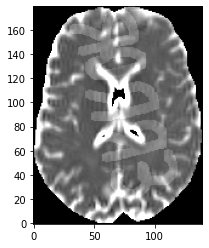

In [16]:
MD1 = tenfit.md

# nib.save(nib.Nifti1Image(MD1.astype(np.float32), img.affine), '/content/example/tensors_md.nii.gz')
plt.imshow(MD1[:,:,1].T, cmap="gray", origin="lower", vmin=0, vmax=2e-3)


Let's see if we can find those pesky outliers causing our ERROR with ROBUST modelling.

In [17]:
tenmodel = dti.TensorModel(gtab, fit_method="WLS", return_S0_hat=True)
tenfit = tenmodel.fit(maskdata)

predict = tenfit.predict(gtab, S0=tenfit.model_S0)
residuals = maskdata - predict
#nib.save(nib.Nifti1Image(residuals.astype(np.float32), img.affine), '/content/example/tensors_residuals.nii.gz')


Text(0, 0.5, 'Z-score')

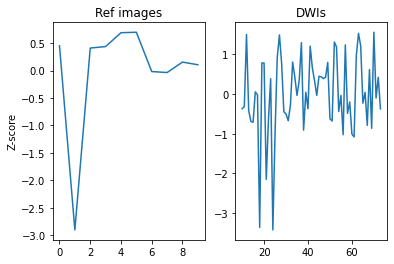

In [18]:
ref_images = gtab.b0s_mask
refs = np.mean(residuals[:,:,:,ref_images], axis=(0,1,2))
dwis = np.mean(residuals[:,:,:,~ref_images], axis=(0,1,2))

refs_mean = np.mean(refs)
refs_std = np.std(refs)
dwis_mean = np.mean(dwis)
dwis_std = np.std(dwis)

refs_z = (refs - refs_mean) / refs_std
dwis_z = (dwis - dwis_mean) / dwis_std

fig, axs = plt.subplots(1,2)
axs[0].plot(refs_z)
axs[0].title.set_text('Ref images')
axs[1].plot(range(10,74), dwis_z)
axs[1].title.set_text('DWIs')
axs[0].set_ylabel('Z-score')


Let's set threshold to 2*std and we might say that one of the reference images and three of the DWIs are outliers. Lets remove them and see what happens!

In [19]:
exclude = [1,18,21,24]
data_robust = np.delete(data, exclude, axis=3)
bvals_robust = np.delete(bvals, exclude, axis=0)
bvecs_robust = np.delete(bvecs, exclude, axis=0)

gtab_robust = gradient_table(bvals_robust, bvecs_robust)

maskdata, mask = median_otsu(data_robust, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
tenmodel_robust = dti.TensorModel(gtab_robust, fit_method="WLS", return_S0_hat=True)
tenfit_robust = tenmodel_robust.fit(maskdata)

predict_robust = tenfit_robust.predict(gtab_robust, S0=tenfit_robust.model_S0)
residuals_robust = maskdata - predict_robust

MD1_robust = tenfit_robust.md

nib.save(nib.Nifti1Image(MD1_robust.astype(np.float32), img.affine), '/content/example/tensors_md_robust.nii.gz')

/usr/local/lib/python3.7/dist-packages/dipy/segment/mask.py:207: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (176, 256, 3) looks like an RGB image
  thresh = otsu(mask)


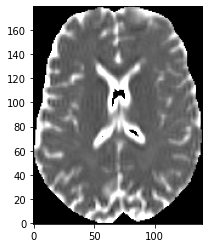

In [20]:
plt.imshow(MD1_robust[:,:,1].T, cmap="gray", origin="lower", vmin=0, vmax=2e-3)

Text(0, 0.5, 'Z-score')

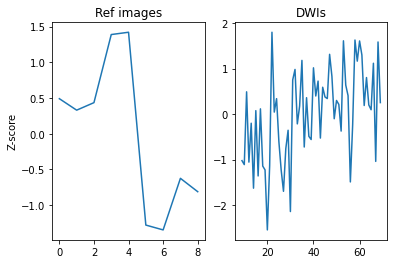

In [21]:
ref_images = gtab_robust.b0s_mask
refs = np.mean(residuals_robust[:,:,:,ref_images], axis=(0,1,2))
dwis = np.mean(residuals_robust[:,:,:,~ref_images], axis=(0,1,2))

refs_mean = np.mean(refs)
refs_std = np.std(refs)
dwis_mean = np.mean(dwis)
dwis_std = np.std(dwis)

refs_z = (refs - refs_mean) / refs_std
dwis_z = (dwis - dwis_mean) / dwis_std

fig, axs = plt.subplots(1,2)
axs[0].plot(refs_z)
axs[0].title.set_text('Ref images')
axs[1].plot(range(9,70), dwis_z)
axs[1].title.set_text('DWIs')
axs[0].set_ylabel('Z-score')